This notebook provides an example of fitting ALMA interferometric images using `lenstronomy`.
- Readers are expected to be familiar with parametric modeling in lenstronomy before going through this notebook.
- An example of basic lenstronomy parametric fitting can be found <a href="https://github.com/lenstronomy/lenstronomy-tutorials/blob/main/Notebooks/LensModeling/modeling_a_simple_Einstein_ring.ipynb" target="_blank">here </a>.
- The method and the corresponding likelihood function used here are described in detail in (placeholder for the paper).

####  A.Please note that this notebook does **not**:
- Cover the calibration steps for interferometric images.
- Handle phase errors.  
    - We assume that the dominant source of noise in the interferometric data comes from random errors in the visibility measurements.

####  B.Required Inputs
- A **naturally weighted** dirty image, dirty beam, and primary beam, all generated by CASA `tclean` (no cleaning performed).
    - The dirty image should **not** be primary beam corrected, for this is handled during the fitting process.
- An estimate of the image-plane noise RMS (used as the `background_rms` parameter).

#### C.Inputs That Should **Not** Be Used
- Dirty images created with weighting schemes other than **natural**.
- **CLEANed** images. Because the likelihood function in this notebook is not valid for CLEANed images.
----

#### Key Differences from Standard lenstronomy Parametric Fitting
##### Changes to `kwargs_data`:
- `kwargs_data['image_data'] = dirty_image_cut` # Insert dirty image here
- `kwargs_data['antenna_primary_beam'] = primary_beam_cut` # Must match size and region of `dirty_image_cut`
- `kwargs_data['likelihood_method'] = 'interferometry_natwt'` # Use the interferometric likelihood function
- `kwargs_data['log_likelihood_constant'] = -20000` # An additive constant to the log-likelihoodparameter estimation. It does not affect the parameter estimation, can be ignored.

##### Requirements for the Dirty Beam (PSF) Input:
For ALMA images, the PSF is the **dirty beam**, provided as a pixelated array.

This PSF also serves as the noise covariance matrix in the likelihood. For this reason, it must meet strict requirements (see the paper for details).
- The PSF size must be an **odd number**, and greater than `2 * numPix - 1`
- The central pixel of the PSF cut must be the center of the dirty beam.
- The central pixel must be **normalized to 1** (as it typically is in CASA `tclean` output)

##### Specifying the PSF Input""

- `psf_type = 'PIXEL'`
- `kernel_size = 201` # must be > 2 * numPix - 1
- `kernel_cut = kernel_util.cut_psf(kernel, kernel_size, normalisation=False)` # normalisation=False to avoid PSF auto-normalization
- `kwargs_psf = {'psf_type': psf_type, 'pixel_size': deltaPix, 'kernel_point_source': kernel_cut,
             'kernel_point_source_normalisation': False}` # 'kernel_point_source_normalisation': False to avoid PSF auto-normalization

In [25]:
import numpy as np
import corner
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt

# lenstronomy imports
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util
import lenstronomy.Util.util as util

np.random.seed(40)

In [39]:
# Import the primary beam map
pb_filename = "data_files\\spt0346sim.pb.fits"
pb = pyfits.getdata(pb_filename)
pb = pb[0][0]
primary_beam=np.nan_to_num(pb)
primary_beam_cut = primary_beam[190:290:1,180:280:1]

# Import the dirty beam (PSF), and store it as "kernel"
psf_filename = "data_files\\spt0346sim.psf.fits"
kernel = pyfits.getdata(psf_filename)
kernel=kernel[0][0]
kernel=kernel[1:480:1,1:480:1]

# Import the dirty image
dirtyimage_filename = "data_files\\spt0346sim.image.fits"
dirty_image = pyfits.getdata(dirtyimage_filename)
dirty_image=dirty_image[0][0]
dirty_image_cut=dirty_image[190:290:1,180:280:1]

C:\Users\ZN\AppData\Local\Temp\ipykernel_16724\497522191.py:8: RuntimeWarning: invalid value encountered in log10
  cr2 = r2.matshow(np.log10(kernel),origin='lower')


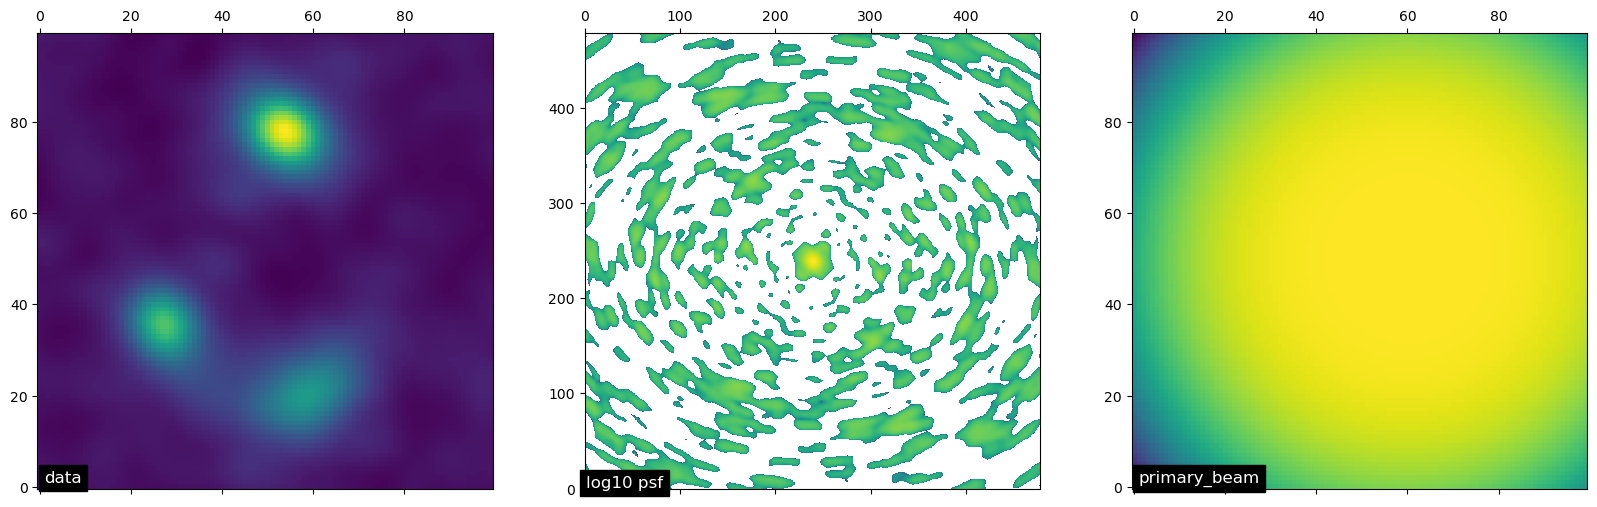

In [3]:
fig = plt.figure(figsize=(20,12))

r1 = fig.add_subplot(131)
cr1 = r1.matshow(dirty_image_cut,origin='lower')
r1.text(1, 1, 'data', fontsize=12,c='w',backgroundcolor='black')

r2 = fig.add_subplot(132)
cr2 = r2.matshow(np.log10(kernel),origin='lower')
r2.text(1, 1, 'log10 psf', fontsize=12,c='w',backgroundcolor='black')

r3 = fig.add_subplot(133)
cr3 = r3.matshow(primary_beam_cut,origin='lower')
r3.text(1, 1, 'primary_beam', fontsize=12,c='w',backgroundcolor='black')

plt.show()

In [4]:
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

In [5]:
# data specifics
background_rms = 3.65e-5  #  background noise per pixel (Gaussian rms value)
exp_time = np.inf  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 100  #  cutout pixel size
deltaPix = 0.035  #  pixel size in arcsec of dirty image, primary beam and dirty beam

kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
kwargs_data['image_data'] = dirty_image_cut
kwargs_data['ra_at_xy_0'] = -(240-180)*deltaPix
kwargs_data['dec_at_xy_0'] = -(240-190)*deltaPix 

kwargs_data['log_likelihood_constant'] = -20000
kwargs_data['likelihood_method'] = 'interferometry_natwt'
kwargs_data['antenna_primary_beam'] = primary_beam_cut

In [6]:
# psf specifics
psf_type = 'PIXEL'
kernel_size = 201

kernel_cut = kernel_util.cut_psf(kernel, kernel_size, normalisation=False)
kwargs_psf = {'psf_type': psf_type, 'pixel_size': deltaPix, 'kernel_point_source': kernel_cut,
             'kernel_point_source_normalisation': False}

In [7]:
# IMPORTANT: lenstronomy supersampling should NOT be used for interferometric image fitting.
# Set `supersampling_factor = 1`, or the fitting will raise an error.

kwargs_numerics = {'supersampling_factor': 1,
                  'supersampling_convolution': False}

single_band = [[kwargs_data, kwargs_psf, kwargs_numerics]]
kwargs_data_joint = {'multi_band_list': single_band, 'multi_band_type': 'multi-linear'}

In [8]:
lens_model_list = ['EPL', 'SHEAR']
source_model_list = ['SERSIC_ELLIPSE']

kwargs_fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []


kwargs_fixed_lens.append({'gamma': 2.0})
kwargs_lens_init.append({'theta_E': 0.9,
   'gamma': 2.0,
   'e1': 0.0,
   'e2': 0.0,
   'center_x': -0.35,
   'center_y': 0.0})
kwargs_lens_sigma.append({'theta_E':0.3,'gamma': 0.1,'center_x': 0.3, 'center_y': 0.3,'e1': 0.3, 'e2': 0.3})
kwargs_lower_lens.append({'theta_E':0.6,'gamma': 1.1,'center_x': -1.35, 'center_y': -1,'e1': -0.5, 'e2': -0.5})
kwargs_upper_lens.append({'theta_E': 1.2,'gamma': 2.5,'center_x': 0.65, 'center_y': 1,'e1': 0.5, 'e2': 0.5})


kwargs_fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append({'gamma1': 0, 'gamma2': 0 })
kwargs_lens_sigma.append({'gamma1': 0.2, 'gamma2': 0.2 })
kwargs_lower_lens.append({'gamma1': -0.4, 'gamma2': -0.4 })
kwargs_upper_lens.append({'gamma1': 0.4, 'gamma2': 0.4 })


lens_params = [kwargs_lens_init, kwargs_lens_sigma, kwargs_fixed_lens, kwargs_lower_lens, kwargs_upper_lens]


kwargs_fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []


kwargs_fixed_source.append({})
kwargs_source_init.append({'amp': 1,
   'R_sersic': 0.2,
   'n_sersic': 1,
   'e1': 0,
   'e2': 0,
   'center_x': -0.35,
   'center_y': -0.0})
kwargs_source_sigma.append({'amp':0.005,
 'R_sersic': 0.15,
 'n_sersic': 0.1,
 'e1': 0.3,
 'e2': 0.3,
 'center_x': 0.3,
 'center_y': 0.3})
kwargs_lower_source.append({'amp':0,
 'R_sersic': 0.03,
 'n_sersic': 0.5,
 'e1': -0.5,
 'e2': -0.5,
 'center_x': -1.35,
 'center_y': -1})
kwargs_upper_source.append({'amp':30,
 'R_sersic': 1.0,
 'n_sersic': 5,
 'e1': 0.5,
 'e2': 0.5,
 'center_x': 0.65,
 'center_y': 1})


source_params = [kwargs_source_init, kwargs_source_sigma, kwargs_fixed_source, kwargs_lower_source, kwargs_upper_source]

In [9]:
kwargs_model = {'lens_model_list': lens_model_list, 'source_light_model_list': source_model_list}
kwargs_likelihood = {}
kwargs_constraints = {}

lens_params = [kwargs_lens_init, kwargs_lens_sigma, kwargs_fixed_lens, kwargs_lower_lens, kwargs_upper_lens]
source_params = [kwargs_source_init, kwargs_source_sigma, kwargs_fixed_source, kwargs_lower_source, kwargs_upper_source]

kwargs_params = {'lens_model': lens_params,
                 'source_model': source_params
                }

In [10]:
from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, mpi=False)

In [11]:
fitting_kwargs_list =[['PSO', {'sigma_scale': 0.99, 'n_particles': 500, 'n_iterations': 1000, 'threadCount': 1}],
                     ['MCMC', {'n_burn': 700, 'n_run': 300, 'walkerRatio':5, 'sigma_scale': 0.02, 'threadCount':1}]]

In [12]:
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

C:\Users\ZN\AppData\Roaming\Python\Python311\site-packages\lenstronomy\Data\psf.py:95: UserWarning: Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.
  warnings.warn(


Computing the PSO ...


 42%|████▏     | 422/1000 [50:20<1:08:57,  7.16s/it]


Converged after 422 iterations!
Best fit found:  -9801.222415334236 [0.9974687605347262, 0.33472773236297415, -0.2656545665888804, -0.59252340867161, -0.32412889226487795, -0.018923452213031208, -0.12194574339130079, 0.0913274069660167, 1.4639998331441544, -0.04130415896576913, 0.10358942545616305, -0.424540532944347, -0.09434868333181007]
-1.9629926728087794 reduced X^2 of best position
-9801.222415334236 log likelihood
9986.0 effective number of data points
[{'theta_E': 0.9974687605347262, 'gamma': 2.0, 'e1': 0.33472773236297415, 'e2': -0.2656545665888804, 'center_x': -0.59252340867161, 'center_y': -0.32412889226487795}, {'gamma1': -0.018923452213031208, 'gamma2': -0.12194574339130079, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.0913274069660167, 'n_sersic': 1.4639998331441544, 'e1': -0.04130415896576913, 'e2': 0.10358942545616305, 'center_x': -0.424540532944347, 'center_y': -0.09434868333181007}] source result
[] lens light result
[] point source result
[] tracer s

100%|██████████| 1000/1000 [18:10<00:00,  1.09s/it]

Computing the MCMC...
Number of walkers =  65
Burn-in iterations:  700
Sampling iterations (in current run): 1000
1091.8838489055634 time taken for MCMC sampling


In [22]:
kwargs_result

{'kwargs_lens': [{'theta_E': 1.0076542616736577,
   'gamma': 2.0,
   'e1': 0.36392536993440183,
   'e2': -0.2777833078511089,
   'center_x': -0.5984161625449789,
   'center_y': -0.331764291024923},
  {'gamma1': -0.0069854031123584,
   'gamma2': -0.12658687608413927,
   'ra_0': 0,
   'dec_0': 0}],
 'kwargs_source': [{'amp': 0.023904824739687434,
   'R_sersic': 0.09326416246823747,
   'n_sersic': 1.4440491205029142,
   'e1': -0.052868175938552364,
   'e2': 0.1085442541548154,
   'center_x': -0.41980243814009677,
   'center_y': -0.094707669434672}],
 'kwargs_lens_light': [],
 'kwargs_ps': [],
 'kwargs_special': {},
 'kwargs_extinction': [],
 'kwargs_tracer_source': []}

In [31]:
from lenstronomy.Plots.model_plot import ModelPlot
modelPlot = ModelPlot([[kwargs_data, kwargs_psf, kwargs_numerics]], kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat", linear_solver=True)

-1.9603585732879005 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.9866142205788047


C:\Users\ZN\AppData\Roaming\Python\Python311\site-packages\lenstronomy\Plots\model_band_plot.py:68: RuntimeWarning: invalid value encountered in log10
  log_model = np.log10(model)


<span style="color:red"><strong>↑Attention:</strong></span>  
The "reduced chi^2 of data" **does not apply** to ALMA image fitting.

- The number of image pixels does **not** correspond to the number of independent degrees of freedom in ALMA data.
- The value of the log-likelihood can be **arbitrarily shifted** by a constant via: ` kwargs_data['log_likelihood_constant'] = *some_constant*`. This constant does not affect the resulting parameter estimation.

C:\Users\ZN\AppData\Roaming\Python\Python311\site-packages\lenstronomy\Plots\model_band_plot.py:161: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
C:\Users\ZN\AppData\Roaming\Python\Python311\site-packages\lenstronomy\Plots\model_band_plot.py:225: RuntimeWarning: invalid value encountered in log10
  np.log10(self._model),


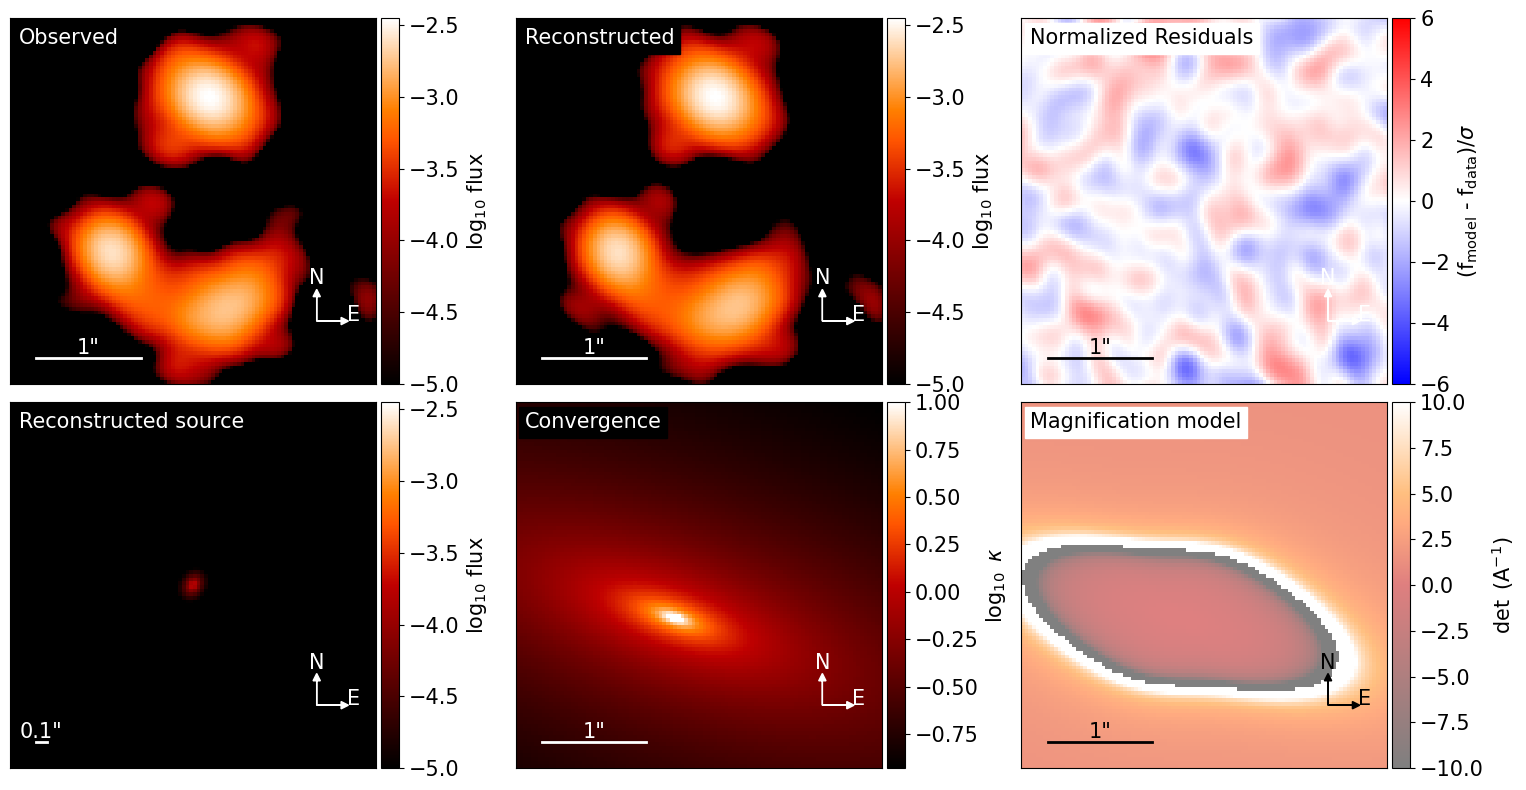

C:\Users\ZN\AppData\Roaming\Python\Python311\site-packages\lenstronomy\Plots\model_band_plot.py:1121: RuntimeWarning: divide by zero encountered in log10
  np.log10(model),
C:\Users\ZN\AppData\Roaming\Python\Python311\site-packages\lenstronomy\Plots\model_band_plot.py:1121: RuntimeWarning: invalid value encountered in log10
  np.log10(model),


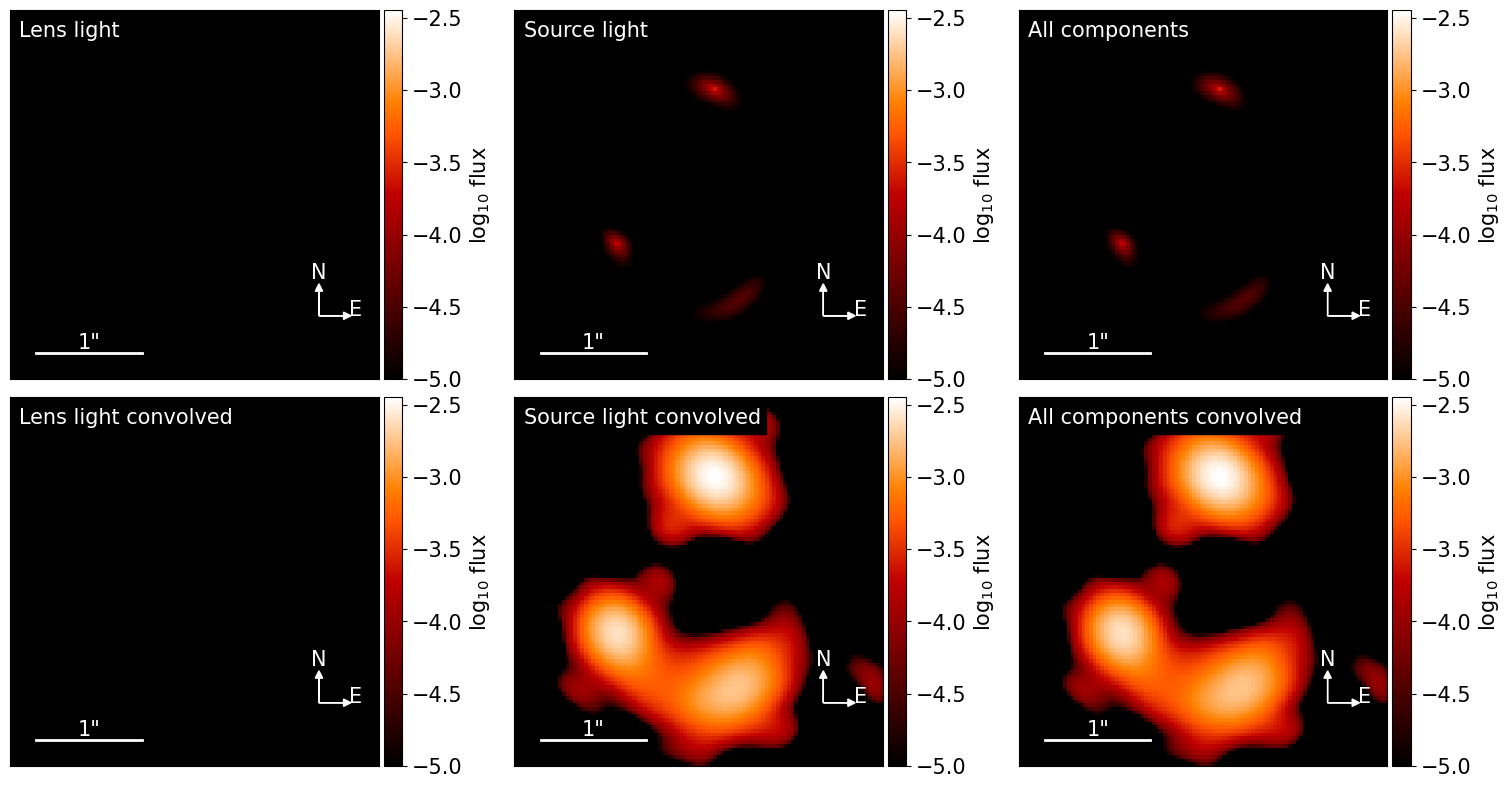

In [32]:
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.035, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
modelPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

In [15]:
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[-1]

C:\Users\ZN\AppData\Local\Temp\ipykernel_16724\4196891459.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc == []:
C:\Users\ZN\AppData\Local\Temp\ipykernel_16724\4196891459.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


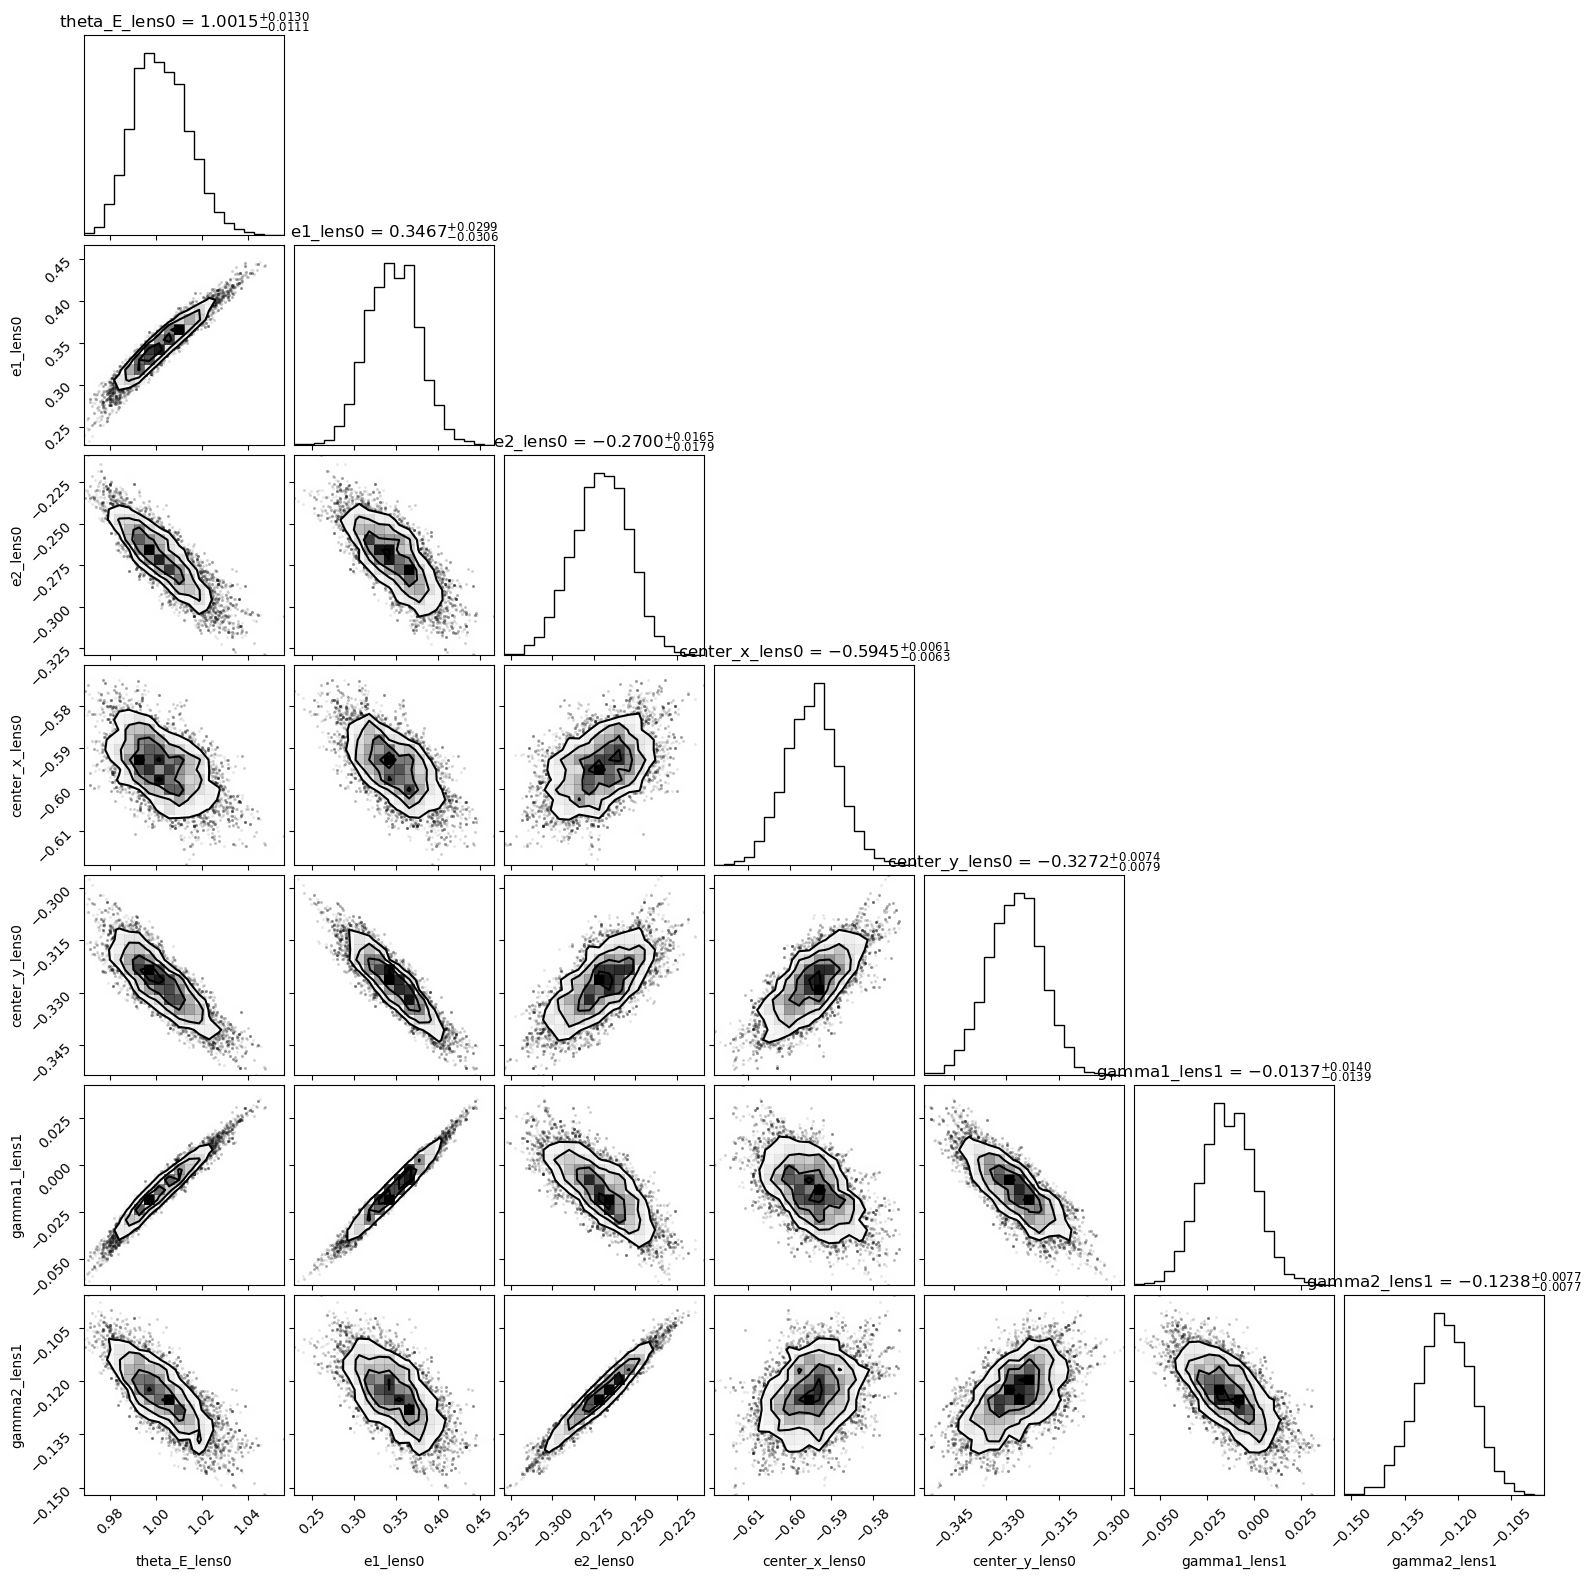

In [16]:
if not samples_mcmc == []:
    n, num_param = np.shape(samples_mcmc)
    plot = corner.corner(samples_mcmc[:,:7], labels=param_mcmc[:7], show_titles=True, title_fmt = ".4f")
    plot.show()

C:\Users\ZN\AppData\Local\Temp\ipykernel_16724\3853212541.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc == []:
C:\Users\ZN\AppData\Local\Temp\ipykernel_16724\3853212541.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


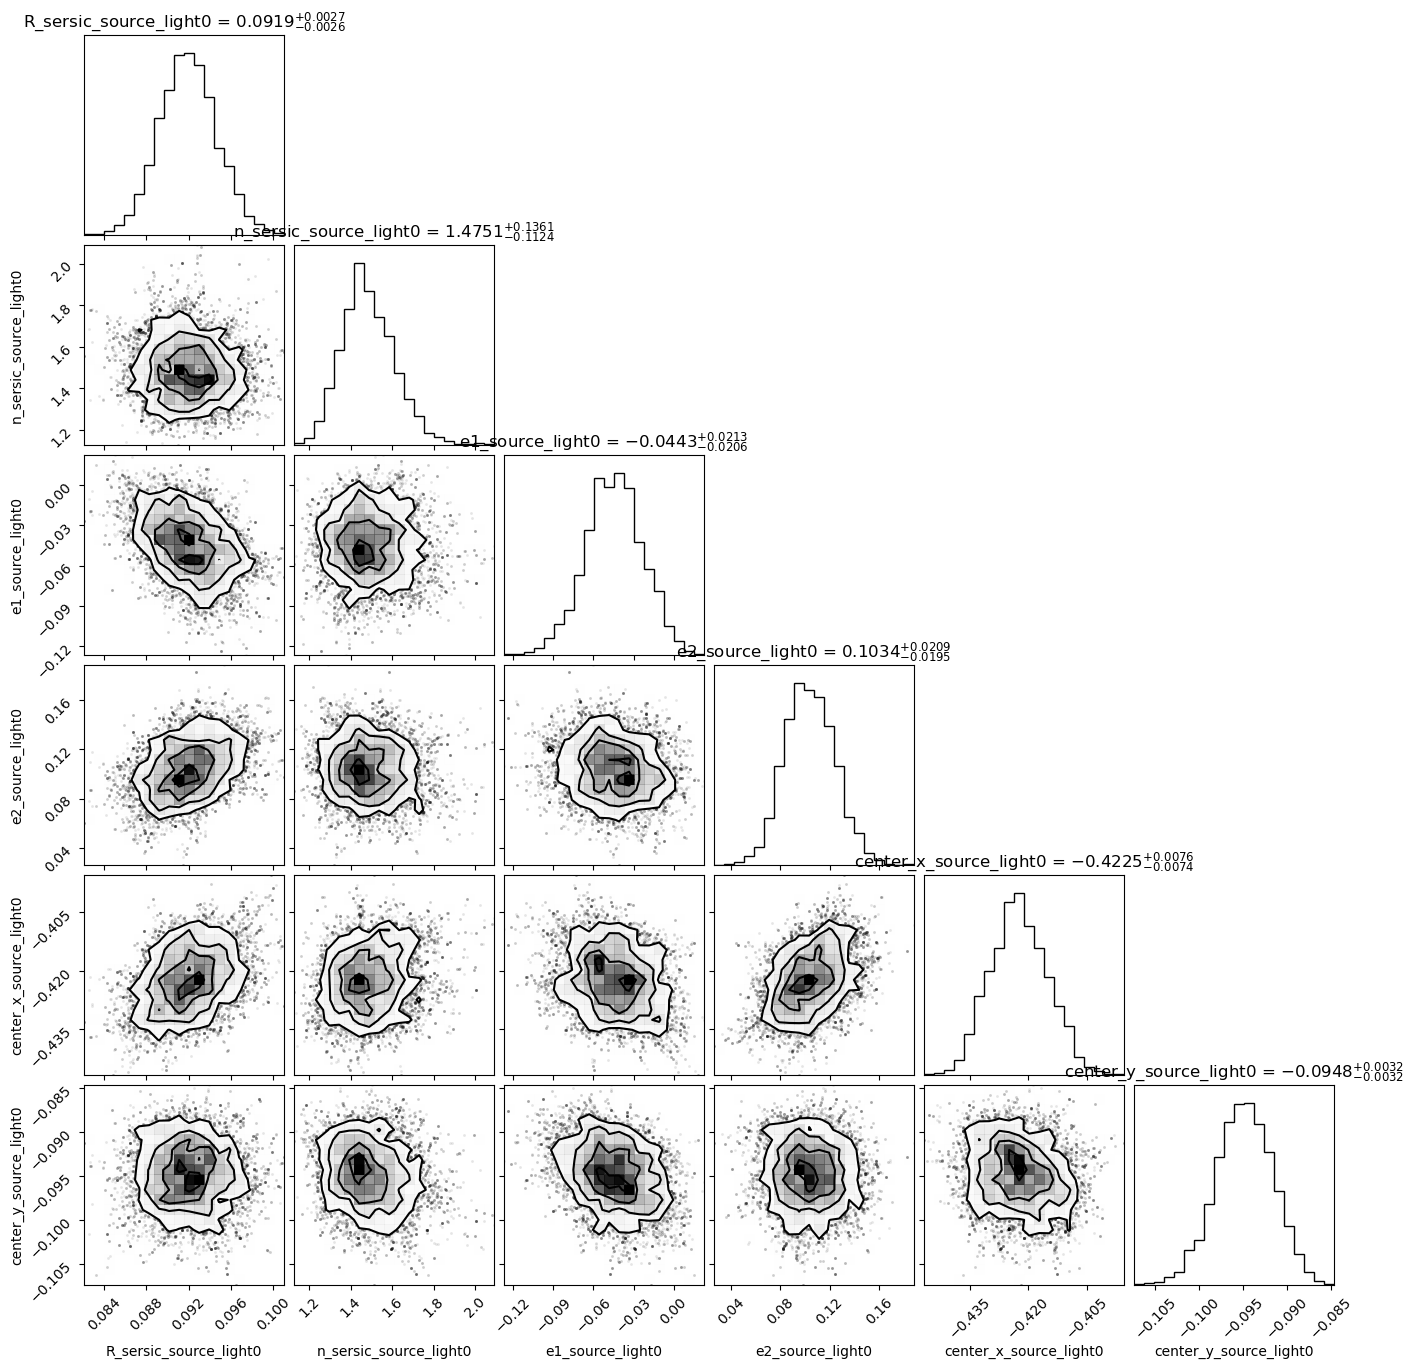

In [17]:
if not samples_mcmc == []:
    n, num_param = np.shape(samples_mcmc)
    plot = corner.corner(samples_mcmc[:,7:13], labels=param_mcmc[7:13], show_titles=True, title_fmt = ".4f")
    plot.show()

In [34]:
# Estimate the source amplitude using a linear solver.
# Note: lenstronomy marginalizes over source amplitude during fitting,
# so `kwargs_result` will not return it.
# If the amplitude is needed, you can compute it directly using the linear solver.

from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.ImSim.image_linear_solve import ImageLinearFit
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel

data_class = ImageData(**kwargs_data)
psf_class = PSF(**kwargs_psf)
lens_model_class = LensModel(lens_model_list=lens_model_list)
source_model_class = LightModel(light_model_list=source_model_list)

imageLinearFit = ImageLinearFit(data_class, psf_class,lens_model_class,source_model_class)
_,_,_, params_coefficient = imageLinearFit.image_linear_solve(kwargs_lens = kwargs_result['kwargs_lens'],
                                                             kwargs_source = kwargs_result['kwargs_source'])
imageLinearFit.update_linear_kwargs(params_coefficient, kwargs_result['kwargs_lens'], kwargs_result['kwargs_source'], kwargs_lens_light=None, kwargs_ps=None)

([{'theta_E': 1.0076542616736577,
   'gamma': 2.0,
   'e1': 0.36392536993440183,
   'e2': -0.2777833078511089,
   'center_x': -0.5984161625449789,
   'center_y': -0.331764291024923},
  {'gamma1': -0.0069854031123584,
   'gamma2': -0.12658687608413927,
   'ra_0': 0,
   'dec_0': 0}],
 [{'amp': 0.023904824739687434,
   'R_sersic': 0.09326416246823747,
   'n_sersic': 1.4440491205029142,
   'e1': -0.052868175938552364,
   'e2': 0.1085442541548154,
   'center_x': -0.41980243814009677,
   'center_y': -0.094707669434672}],
 None,
 None)